# Comparing and Clustering Images - Wikimania Tutorial :)
## This notebook contains a set of quick scripts to compare images based on their content. 
#### Content includes color distribution and objects.



##### Requirements
* OPENCV: pip install opencv-python
* Tensorflow: pip install tensorflow==1.14.0
* Numpy/Math/Matplotlib (probably you have them already)
* Scipy and Sklearn
* All files/scripts in this folder

In [47]:

'''
importing the libraries
'''
#general
import math
import json
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

#for matrix computations and plotting
import cv2
import numpy as np
from scipy import spatial
from sklearn.cluster import KMeans

#you will have to have tensorflow installed to run the code in the file below. 
import image_feature_tensorflow as tfeature



In [76]:
'''
A couple of useful plotting functions - let's skip the details, this is just for us to visulize the images we are dealing with
'''

def plot_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #transforming to rgb for visualization
    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    plt.imshow(img_rgb)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def plot_clusters(nrows,ncols,imgs):
    _, axs = plt.subplots(nrows, ncols, figsize=(12, 6))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.show()
    


## Comparing Images
###  Goal: finding similarity between two images
First, we compute features on the images, then we compute similarity between images.
__Important: Similarity between images can be computed only if the 2 images are described usign the same features, we can't compare images of different sizes directly__

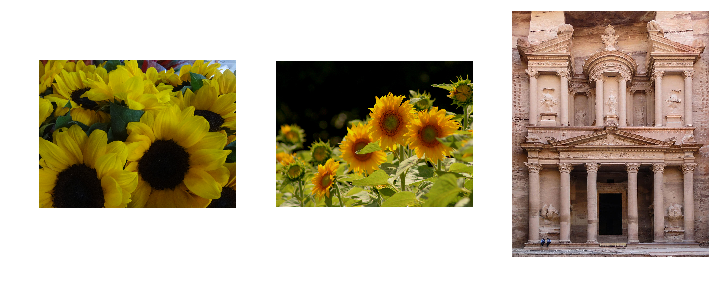

In [77]:
'''
here we read and plot an image, and try to understand what the image is made of
'''
sunflower1= cv2.imread('images/for_comparison/sunflowers_1.jpg')
sunflower2 = cv2.imread('images/for_comparison/sunflowers_2.jpg')
petra = cv2.imread('images/for_comparison/petra.jpg')
plot_clusters(1,3,[sunflower1,sunflower2,petra])


In [65]:
'''
What are the dominant colors of an image? 
Just count the number of pixels in the hue space belonging to each color.
'''
def extract_color_distribution(img):
    hsv_img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert irgbto hsv
    h,s,v = cv2.split(hsv_img)
    #creating a dictionary of 12 colors sampled from the hue space
    color_names=['Red','Orange','Yellow','Yellow-Green','Green','Aqua',
                 'Cyan','Azure','Blue','Violet','Magenta,','Rose'] 
    #quantize each pixel from a value in the range (180) to a value between 0 and 11
    h_quant=np.floor(np.divide(h,15)) 
    #compute distribution over these 12 values
    color_values=np.histogram(h_quant,12)[0]
    color_values=color_values/float(h.shape[0]*h.shape[1])
    #assign a label to each bin of the color distribution
    color_dict={color_names[i]:color_values[i] for i in range(len(color_values))}
    return color_dict
'''
What are the dominant objects of an image? 
use Imagenet classifier to get probabilities of 1000 objects
'''
def extract_objects(img):
    return tfeature.classify(img)

'''
How distant are 2 images? Use cosine distance to infer similarity between 2 images
'''
def compare_images(dic1,dic2):
    return spatial.distance.cosine(np.asarray(dic1.values()),np.asarray(dic2.values()))

In [66]:
'''
Extracting color dictionary from the hue channel of the original image
'''
color_sunflower1=extract_color_distribution(sunflower1)
color_sunflower2=extract_color_distribution(sunflower2)
color_petra=extract_color_distribution(petra)

In [67]:
compare_images(color_sunflower1,color_sunflower2)

0.1998781550229658

In [68]:
compare_images(color_sunflower1,color_petra)

0.8575786035356479

In [69]:
compare_images(color_sunflower2,color_petra)

0.4990725148955968

In [70]:
'''
Maybe Color Distribution is not enough to evaluate similarity between paintings, 
let's compute object distribution
'''
object_sunflower1=extract_objects('images/for_comparison/sunflowers_1.jpg')
object_sunflower2=extract_objects('images/for_comparison/sunflowers_2.jpg')
object_petra=extract_objects('images/for_comparison/petra.jpg')



In [71]:
compare_images(object_sunflower1,object_sunflower2)

0.003876845560471409

In [72]:
compare_images(object_virgin,object_sunflower2)

0.9993333349592431

In [73]:
compare_images(object_virgin,object_sunflower1)

0.9988065421549768

## Clustering Images
###  Goal: finding groups of images with similar characteristics
First, we compute features on the images, then we use kmeans to cluster images.


In [43]:
'''
Let's load, read, and compute color features for all images in a folder
'''
image_dir='images/for_clustering'
onlyfiles = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]
raw_images={}
color_features={}
obj_features={}
for image in onlyfiles:
    filename=join(image_dir, image)
    raw_images[image]=cv2.imread(filename)
    color_features[image]=extract_color_distribution(raw_images[image]).values()
    obj_features[image]=extract_objects(filename).values()



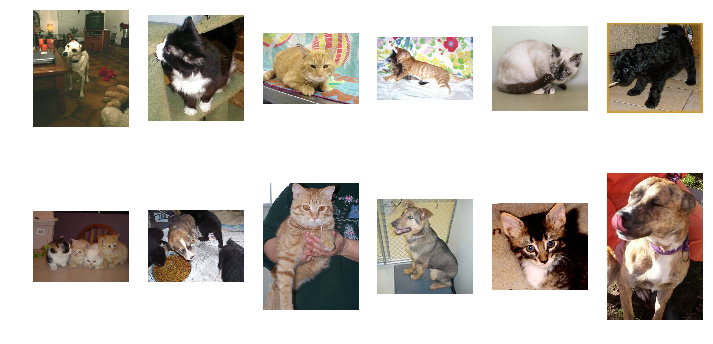

In [78]:
plot_clusters(2,6,raw_images.values()[:12])

In [86]:
def cluster_images(features,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features.values())
    assigned={features.keys()[i]:kmeans.labels_[i] for i in range(len(features))}
    return assigned

def plot_clustered_images(labels,raw):
    k=set(labels.values())
    groups={i:[] for i in k}
    for image in labels:
        i=labels[image]
        groups[i].append(raw[image])
    for i in k:
        print("cluster "+ str(i+1))
        plot_clusters(3,3,np.random.choice(groups[i], 9))
        


cluster 1


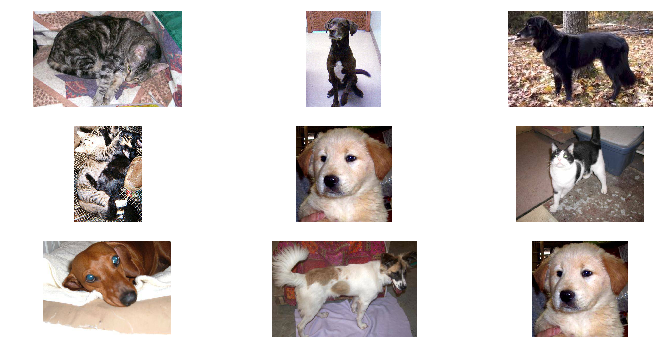

cluster 2


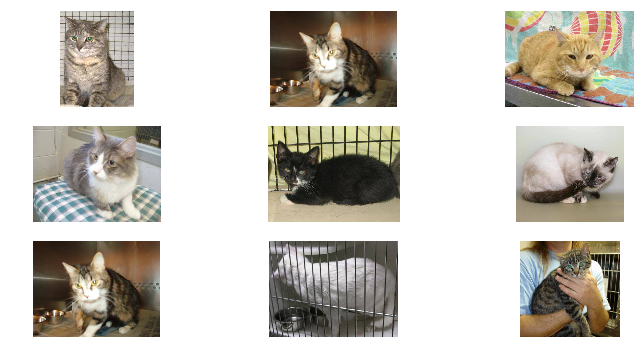

In [87]:
labels=cluster_images(color_features,2)
plot_clustered_images(labels,raw_images)

cluster 1


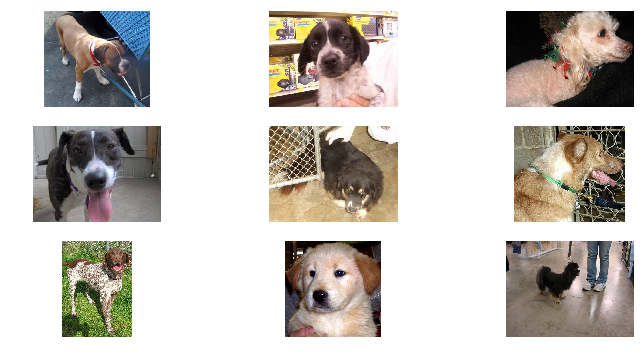

cluster 2


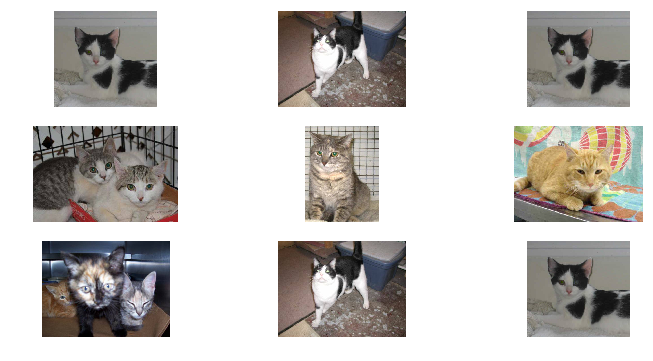

In [88]:
labels=cluster_images(obj_features,2)
plot_clustered_images(labels,raw_images)